In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc, distinct

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
# inspector = inspect(engine)

# columns = inspector.get_columns('Measurement')
# for column in columns:
#     print(column["name"], column["type"])
   
max_date = session.query(func.max(Measurement.date))

for row in max_date:
    print(row[0])

2017-08-23


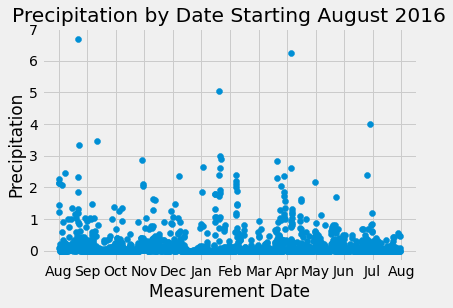

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
#!! I got an error when I tried to select only two columns

year_of_data = session.query(Measurement.id,Measurement.station, Measurement.date, Measurement.prcp,Measurement.tobs).\
        order_by(Measurement.date.desc()).filter(Measurement.date > query_date)

# Save the query results as a Pandas DataFrame and set the index to the date column

#!! Also got an error if I only selected two columns

precip_data = pd.DataFrame(year_of_data, columns=['id','station','date','prcp','tobs'])
precip_data.set_index('date', inplace = True,)


# Sort the dataframe by date

precip_data = precip_data.sort_values(by="date")

# Use Pandas Plotting with Matplotlib to plot the data

x_values = precip_data.reset_index()['date']
y_values = precip_data['prcp']

months = ['Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug']
plt.xticks(np.linspace(0,365,13), months)

plt.scatter(x_values,y_values)

plt.xlabel('Measurement Date')
plt.ylabel('Precipitation')
plt.title('Precipitation by Date Starting August 2016')
# plt.grid()
plt.show()
# plt.savefig("../output_data/nhtemplat.png")

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data

##Not a very descriptive assignment. 
precip_data2 = pd.DataFrame(year_of_data, columns=['id','station','date','prcp','tobs'])

SummaryGrp = precip_data2.groupby('date')

SummaryGrp_data = SummaryGrp.agg({"prcp": ["mean","median","var","std","sem"]}) 

SummaryGrp_data.columns = ["Mean","Median","Variance","Standard Deviation","SEM"]

print(SummaryGrp_data)

                Mean  Median  Variance  Standard Deviation       SEM
date                                                                
2016-08-24  1.555000   1.800  0.706510            0.840541  0.343150
2016-08-25  0.077143   0.080  0.005157            0.071813  0.027143
2016-08-26  0.016667   0.015  0.000267            0.016330  0.006667
2016-08-27  0.064000   0.020  0.006680            0.081731  0.036551
2016-08-28  0.516667   0.140  0.620427            0.787672  0.321566
...              ...     ...       ...                 ...       ...
2017-08-19  0.030000   0.000  0.002700            0.051962  0.030000
2017-08-20  0.005000   0.005  0.000050            0.007071  0.005000
2017-08-21  0.193333   0.020  0.100933            0.317700  0.183424
2017-08-22  0.166667   0.000  0.083333            0.288675  0.166667
2017-08-23  0.132500   0.040  0.046225            0.215000  0.107500

[365 rows x 5 columns]


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset


Stations = session.query(Measurement.station).distinct().count()
print(f"There are {Stations} stations in the dataset")

There are 9 stations in the dataset


In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.station).label('count'),Station.id).\
        filter(Measurement.station == Station.station).\
        group_by(Measurement.station).order_by(desc('count')).all()



[('USC00519281', 2772, 7),
 ('USC00519397', 2724, 1),
 ('USC00513117', 2709, 2),
 ('USC00519523', 2669, 6),
 ('USC00516128', 2612, 9),
 ('USC00514830', 2202, 3),
 ('USC00511918', 1979, 8),
 ('USC00517948', 1372, 4),
 ('USC00518838', 511, 5)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# inspector = inspect(engine)

# columns = inspector.get_columns('Station')
# for column in columns:
#     print(column["name"], column["type"])

session.query(Measurement.station, Station.id, func.max(Measurement.tobs), func.min(Measurement.tobs), \
              func.avg(Measurement.tobs)).filter(Station.id == '7',\
              Measurement.station == Station.station).distinct().all()

[('USC00519281', 7, 85.0, 54.0, 71.66378066378067)]

array([[<AxesSubplot:title={'center':'tobs'}>]], dtype=object)

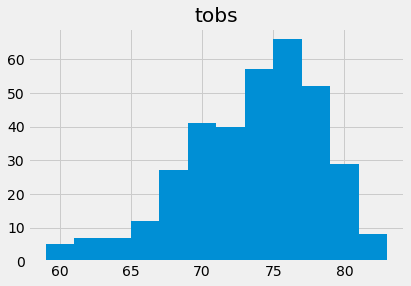

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

temp_year = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > query_date,\
            Station.id == '7',Measurement.station == Station.station)

dftemp_year = pd.DataFrame(temp_year, columns=['date','tobs'])
dftemp_year.hist(bins = 12)




# Close session

In [16]:
# Close Session
session.close()